In [1]:
# --- 1. GEREKLİ KÜTÜPHANELERİ YÜKLEME ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # IterativeImputer için gerekli
from sklearn.impute import IterativeImputer
from scipy import interpolate
import matplotlib as mpl
import warnings
import GEOparse
warnings.filterwarnings('ignore')  # Uyarıları gizle

# GEO veritabanından GSE2034 veri setini indirme
# Bu veri seti meme kanseri hastalarının gen ekspresyon profillerini içeriyor
print("Veri indiriliyor, bu işlem birkaç dakika sürebilir...")
gse = GEOparse.get_GEO(geo="GSE2034", destdir="./data")
# Ekspresyon matrisini oluşturma - satırlar=genler, sütunlar=örnekler
exprs = gse.pivot_samples('VALUE')
print(f"Ekspresyon matrisinin boyutu: {exprs.shape}")

print("Veri başarıyla indirildi!")

11-Mar-2025 12:06:46 DEBUG utils - Directory ./data already exists. Skipping.
11-Mar-2025 12:06:46 INFO GEOparse - File already exist: using local version.
11-Mar-2025 12:06:46 INFO GEOparse - Parsing ./data/GSE2034_family.soft.gz: 
11-Mar-2025 12:06:46 DEBUG GEOparse - DATABASE: GeoMiame
11-Mar-2025 12:06:46 DEBUG GEOparse - SERIES: GSE2034
11-Mar-2025 12:06:46 DEBUG GEOparse - PLATFORM: GPL96


Veri indiriliyor, bu işlem birkaç dakika sürebilir...


11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36777
11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36778
11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36779
11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36780
11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36781
11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36782
11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36783
11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36784
11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36785
11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36786
11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36787
11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36788
11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36789
11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36790
11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36791
11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36792
11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36793
11-Mar-2025 12:06:47 DEBUG GEOparse - SAMPLE: GSM36794
11-Mar-202

11-Mar-2025 12:06:49 DEBUG GEOparse - SAMPLE: GSM36926
11-Mar-2025 12:06:49 DEBUG GEOparse - SAMPLE: GSM36927
11-Mar-2025 12:06:49 DEBUG GEOparse - SAMPLE: GSM36928
11-Mar-2025 12:06:49 DEBUG GEOparse - SAMPLE: GSM36929
11-Mar-2025 12:06:49 DEBUG GEOparse - SAMPLE: GSM36930
11-Mar-2025 12:06:49 DEBUG GEOparse - SAMPLE: GSM36931
11-Mar-2025 12:06:49 DEBUG GEOparse - SAMPLE: GSM36932
11-Mar-2025 12:06:49 DEBUG GEOparse - SAMPLE: GSM36933
11-Mar-2025 12:06:49 DEBUG GEOparse - SAMPLE: GSM36934
11-Mar-2025 12:06:49 DEBUG GEOparse - SAMPLE: GSM36935
11-Mar-2025 12:06:49 DEBUG GEOparse - SAMPLE: GSM36936
11-Mar-2025 12:06:49 DEBUG GEOparse - SAMPLE: GSM36937
11-Mar-2025 12:06:49 DEBUG GEOparse - SAMPLE: GSM36938
11-Mar-2025 12:06:49 DEBUG GEOparse - SAMPLE: GSM36939
11-Mar-2025 12:06:49 DEBUG GEOparse - SAMPLE: GSM36940
11-Mar-2025 12:06:49 DEBUG GEOparse - SAMPLE: GSM36941
11-Mar-2025 12:06:49 DEBUG GEOparse - SAMPLE: GSM36942
11-Mar-2025 12:06:50 DEBUG GEOparse - SAMPLE: GSM36943
11-Mar-202

Ekspresyon matrisinin boyutu: (22283, 286)
Veri başarıyla indirildi!


In [2]:
# --- 2. GÖRSEL AYARLAR ---
# Daha güzel grafikler için stil ayarları
plt.style.use('seaborn-v0_8')
sns.set_context("talk")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 20

# Tutarlı renk paleti
colors = sns.color_palette("husl", 7)
color_dict = {
    'Orijinal': 'black',
    'Ortalama': colors[0],
    'Medyan': colors[1],
    'Sıfır': colors[2],
    'Forward Fill': colors[3],
    'İnterpolasyon': colors[4],
    'KNN': colors[5]
}

In [3]:
# --- 3. EKSİK VERİ OLUŞTURMA ---
np.random.seed(42)  # Tekrarlanabilirlik için
exprs_original = exprs.copy()  # Orijinal veriyi saklayalım
exprs_with_missing = exprs.copy()

# Daha kontrollü eksik veri oluşturma - %5 oranında eksik değer
print("Eksik veri oluşturuluyor...", end="")
original_mask = np.random.random(size=exprs.shape) < 0.05  # Önemli: mask'i original_mask olarak tanımlıyoruz
exprs_with_missing[original_mask] = np.nan
print(" Tamamlandı!")

Eksik veri oluşturuluyor... Tamamlandı!


In [4]:
# --- 4. EKSİK VERİ İSTATİSTİKLERİ ---
# Eksik değerlerin istatistiğini göster
missing_count = exprs_with_missing.isnull().sum().sum()
missing_percentage = (missing_count / exprs_with_missing.size) * 100
print(f"\n📊 EKSİK VERİ İSTATİSTİKLERİ")
print(f"┌{'─'*50}┐")
print(f"│ Toplam örnek sayısı: {exprs.shape[1]:,}{' '*29}│")
print(f"│ Toplam gen sayısı: {exprs.shape[0]:,}{' '*30}│")
print(f"│ Oluşturulan eksik değer sayısı: {missing_count:,}{' '*17}│")
print(f"│ Eksik değerlerin yüzdesi: {missing_percentage:.2f}%{' '*23}│")
print(f"└{'─'*50}┘")

# En çok eksik değere sahip geni ve örneği bulalım
missing_by_gene = exprs_with_missing.isnull().sum(axis=1)
most_missing_gene = missing_by_gene.idxmax()
missing_by_sample = exprs_with_missing.isnull().sum(axis=0)
most_missing_sample = missing_by_sample.idxmax()

print(f"\n▶ En çok eksik değere sahip gen: {most_missing_gene}")
print(f"  Eksik değer sayısı: {missing_by_gene.max()}")
print(f"▶ En çok eksik değere sahip örnek: {most_missing_sample}")
print(f"  Eksik değer sayısı: {missing_by_sample.max()}")


📊 EKSİK VERİ İSTATİSTİKLERİ
┌──────────────────────────────────────────────────┐
│ Toplam örnek sayısı: 286                             │
│ Toplam gen sayısı: 22,283                              │
│ Oluşturulan eksik değer sayısı: 318,569                 │
│ Eksik değerlerin yüzdesi: 5.00%                       │
└──────────────────────────────────────────────────┘

▶ En çok eksik değere sahip gen: 219360_s_at
  Eksik değer sayısı: 31
▶ En çok eksik değere sahip örnek: GSM36900
  Eksik değer sayısı: 1207


In [5]:
# --- 5. FARKLI DOLDURMA STRATEJİLERİ UYGULAMA ---
print("\nDOLDURMA STRATEJİLERİ UYGULANIYOR...")

# 1. Ortalama (Mean) ile doldurma
exprs_mean = exprs_with_missing.fillna(exprs_with_missing.mean())
print("✓ Ortalama ile doldurma tamamlandı")

# 2. Medyan (Median) ile doldurma
exprs_median = exprs_with_missing.fillna(exprs_with_missing.median())
print("✓ Medyan ile doldurma tamamlandı")

# 3. Sabit değer (0) ile doldurma
exprs_zero = exprs_with_missing.fillna(0)
print("✓ Sıfır ile doldurma tamamlandı")

# 4. Forward fill (bir önceki değeri kullanma)
exprs_ffill = exprs_with_missing.fillna(method='ffill', axis=1)
exprs_ffill = exprs_ffill.fillna(method='bfill', axis=1)  # Kalan eksikleri doldurma
print("✓ Forward fill ile doldurma tamamlandı")

# 5. Doğrusal interpolasyon
exprs_interp = exprs_with_missing.interpolate(method='linear', axis=1)
exprs_interp = exprs_interp.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
print("✓ Doğrusal interpolasyon ile doldurma tamamlandı")

# 6. K-en yakın komşu (KNN) ile doldurma
print("✓ KNN ile doldurma başlatılıyor (bu işlem biraz zaman alabilir)...", end="")
knn_imputer = KNNImputer(n_neighbors=5)
exprs_knn = pd.DataFrame(
    knn_imputer.fit_transform(exprs_with_missing.T).T,
    index=exprs_with_missing.index,
    columns=exprs_with_missing.columns
)
print(" Tamamlandı!")


DOLDURMA STRATEJİLERİ UYGULANIYOR...
✓ Ortalama ile doldurma tamamlandı
✓ Medyan ile doldurma tamamlandı
✓ Sıfır ile doldurma tamamlandı
✓ Forward fill ile doldurma tamamlandı
✓ Doğrusal interpolasyon ile doldurma tamamlandı
✓ KNN ile doldurma başlatılıyor (bu işlem biraz zaman alabilir)... Tamamlandı!


In [6]:
# --- 6. PERFORMANS DEĞERLENDİRME ---
# Ortalama Karesel Hata (MSE) hesaplama
def calculate_mse(imputed_df):
    mask_values = exprs_original.values[original_mask]
    imputed_values = imputed_df.values[original_mask]
    return np.mean((mask_values - imputed_values) ** 2)

# Tüm yöntemlerin MSE değerlerini hesapla
methods = {
    'Ortalama': exprs_mean,
    'Medyan': exprs_median,
    'Sıfır': exprs_zero,
    'Forward Fill': exprs_ffill,
    'İnterpolasyon': exprs_interp,
    'KNN': exprs_knn
}

mse_results = {}
for name, df in methods.items():
    mse_results[name] = calculate_mse(df)

# MSE sonuçlarını gösterme
print("\nMEAN SQUARED ERROR (MSE) SONUÇLARI")
mse_df = pd.DataFrame(list(mse_results.items()), columns=['Yöntem', 'MSE'])
mse_df = mse_df.sort_values('MSE')
print(mse_df.to_string(index=False))


MEAN SQUARED ERROR (MSE) SONUÇLARI
       Yöntem          MSE
          KNN 8.344134e+05
İnterpolasyon 1.997636e+06
 Forward Fill 2.659837e+06
     Ortalama 1.067609e+07
       Medyan 1.118893e+07
        Sıfır 1.158966e+07


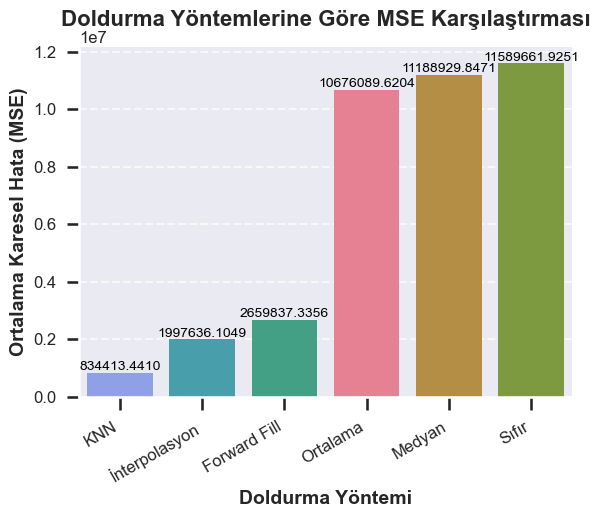

In [7]:
# --- 7. GELİŞTİRİLMİŞ GÖRSELLEŞTİRMELER ---

# 7.1. MSE Karşılaştırması (Bar plot)
plt.figure(figsize=(14, 10))
ax1 = plt.subplot(2, 2, 1)
bars = sns.barplot(x='Yöntem', y='MSE', data=mse_df, palette=[color_dict[x] for x in mse_df['Yöntem']], ax=ax1)

# Bar değerlerini ekle
for i, bar in enumerate(bars.patches):
    bars.text(
        bar.get_x() + bar.get_width()/2.,
        bar.get_height() + 0.02,
        f'{bar.get_height():.4f}',
        ha='center', va='bottom', 
        fontsize=10, color='black',
        rotation=0
    )

ax1.set_title('Doldurma Yöntemlerine Göre MSE Karşılaştırması', fontweight='bold', pad=15)
ax1.set_xlabel('Doldurma Yöntemi', fontweight='bold')
ax1.set_ylabel('Ortalama Karesel Hata (MSE)', fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

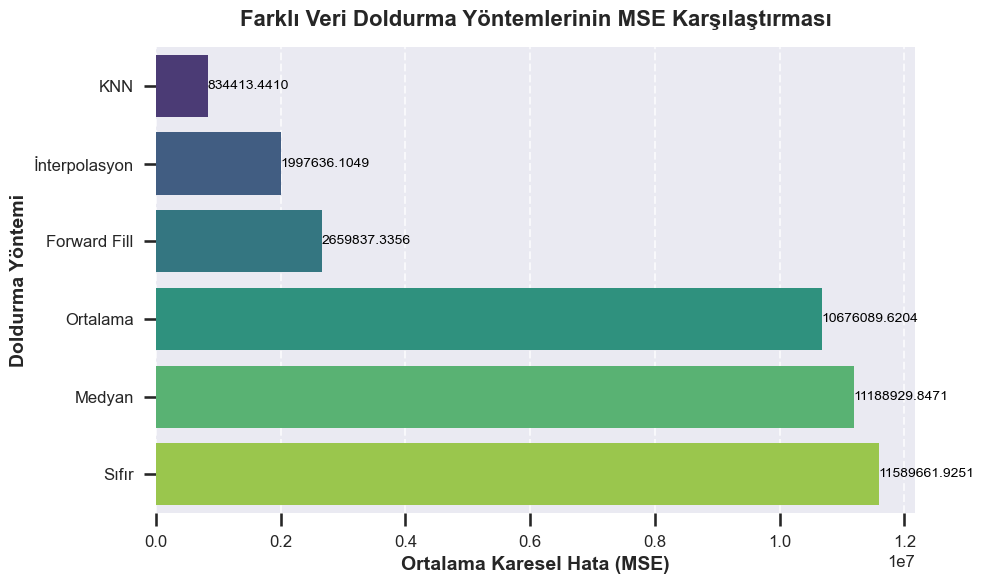

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Varsayılan olarak rastgele veri içeren bir dataframe oluşturuyoruz.
data = {'Yöntem': ['Yöntem A', 'Yöntem B', 'Yöntem C', 'Yöntem D'],
        'MSE': [0.1, 0.25, 0.05, 0.15]}
mse_df

# Renk paleti seçimi (örneğin, viridis)
palette = sns.color_palette('viridis', n_colors=len(mse_df))

plt.figure(figsize=(10, 6))
bars = sns.barplot(x='MSE', y='Yöntem', data=mse_df, palette=palette)

# Bar değerlerini ekleme
for i, bar in enumerate(bars.patches):
    bars.text(
        bar.get_width() + 0.01,
        bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.4f}',
        ha='left', va='center',
        fontsize=10, color='black'
    )

plt.title('Farklı Veri Doldurma Yöntemlerinin MSE Karşılaştırması', fontweight='bold', pad=15)
plt.xlabel('Ortalama Karesel Hata (MSE)', fontweight='bold')
plt.ylabel('Doldurma Yöntemi', fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)  # Eksen çizgilerini kaldır
plt.tight_layout()
plt.show()

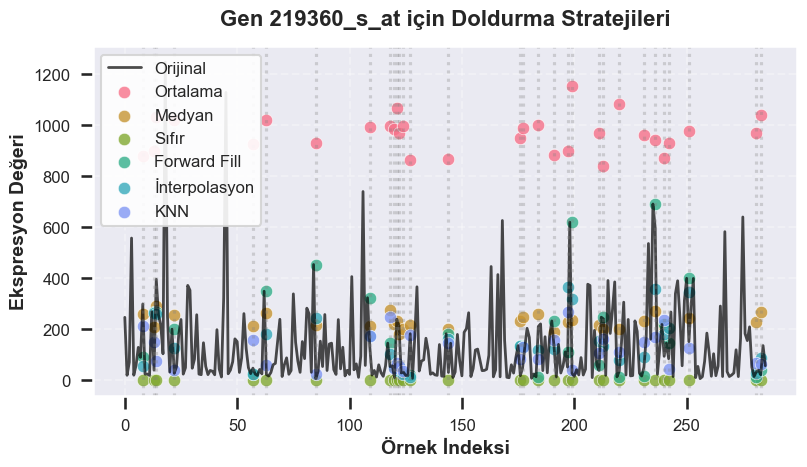

In [9]:
# 7.2. Seçili Gen için Yöntem Karşılaştırması (Scatter plot)
plt.figure(figsize=(20, 10))
ax2 = plt.subplot(2, 2, 2)

# Eksik değer indeksleri
missing_idx = np.where(np.isnan(exprs_with_missing.loc[most_missing_gene]))[0]

# Orijinal değerleri çizme
ax2.plot(range(len(exprs_original.loc[most_missing_gene])), 
        exprs_original.loc[most_missing_gene], 
        color=color_dict['Orijinal'], linestyle='-', linewidth=2,
        label='Orijinal', alpha=0.7)

# Her bir yöntemin doldurulmuş değerlerini çizme
for name, df in methods.items():
    ax2.scatter(missing_idx, 
               df.loc[most_missing_gene].iloc[missing_idx], 
               label=name, alpha=0.8, color=color_dict[name], s=80,
               edgecolor='white', linewidth=0.5)

# Eksik değerlerin yerlerini gösterme
for idx in missing_idx:
    ax2.axvline(x=idx, color='gray', linestyle=':', alpha=0.3)

ax2.set_title(f'Gen {most_missing_gene} için Doldurma Stratejileri', fontweight='bold', pad=15)
ax2.set_xlabel('Örnek İndeksi', fontweight='bold')
ax2.set_ylabel('Ekspresyon Değeri', fontweight='bold')
ax2.legend(frameon=True, framealpha=0.9, facecolor='white', edgecolor='lightgray')
ax2.grid(linestyle='--', alpha=0.3)

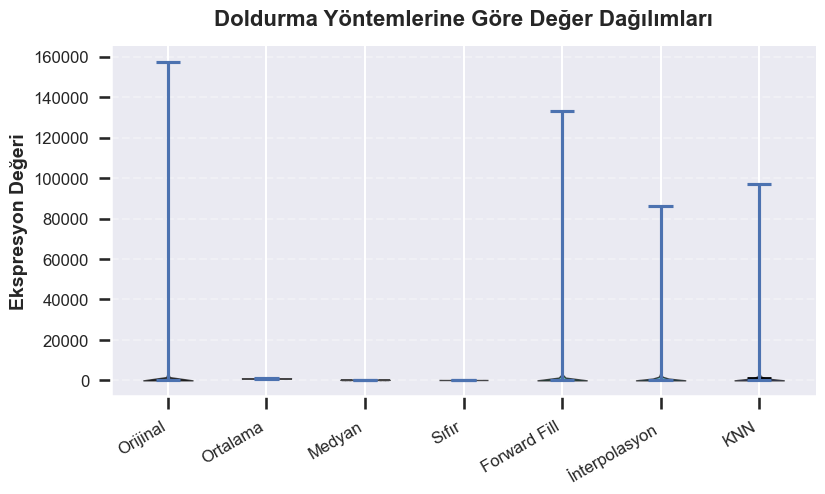

In [10]:
# 7.3. Dağılım Karşılaştırması (Violin plot)
plt.figure(figsize=(20, 10))
ax3 = plt.subplot(2, 2, 3)

# Veri setlerini bir araya getirme
plot_data = []
plot_labels = []

# Orijinal veri
plot_data.append(exprs_original.values.flatten())
plot_labels.append('Orijinal')

# Doldurulmuş değerler (sadece eksik değerlerin olduğu pozisyonlar)
for name, df in methods.items():
    missing_filled = df.values[original_mask]  # original_mask kullanıyoruz!
    plot_data.append(missing_filled)
    plot_labels.append(name)

# Geliştirilmiş violin plot
violins = ax3.violinplot(plot_data, showmeans=True, showmedians=False)

# Violin plotları renklendirme
for i, (violin, name) in enumerate(zip(violins['bodies'], plot_labels)):
    violin.set_facecolor(color_dict[name])
    violin.set_alpha(0.7)
    violin.set_edgecolor('black')
    violin.set_linewidth(1)

# Mean markers
for i, line in enumerate(violins['cmeans'].get_segments()):
    violins['cmeans'].set_segments([line])
    violins['cmeans'].set_linewidth(2)
    violins['cmeans'].set_color('black')

ax3.set_xticks(range(1, len(plot_labels) + 1))
ax3.set_xticklabels(plot_labels, rotation=30, ha='right')
ax3.set_title('Doldurma Yöntemlerine Göre Değer Dağılımları', fontweight='bold', pad=15)
ax3.set_ylabel('Ekspresyon Değeri', fontweight='bold')
ax3.grid(axis='y', linestyle='--', alpha=0.3)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

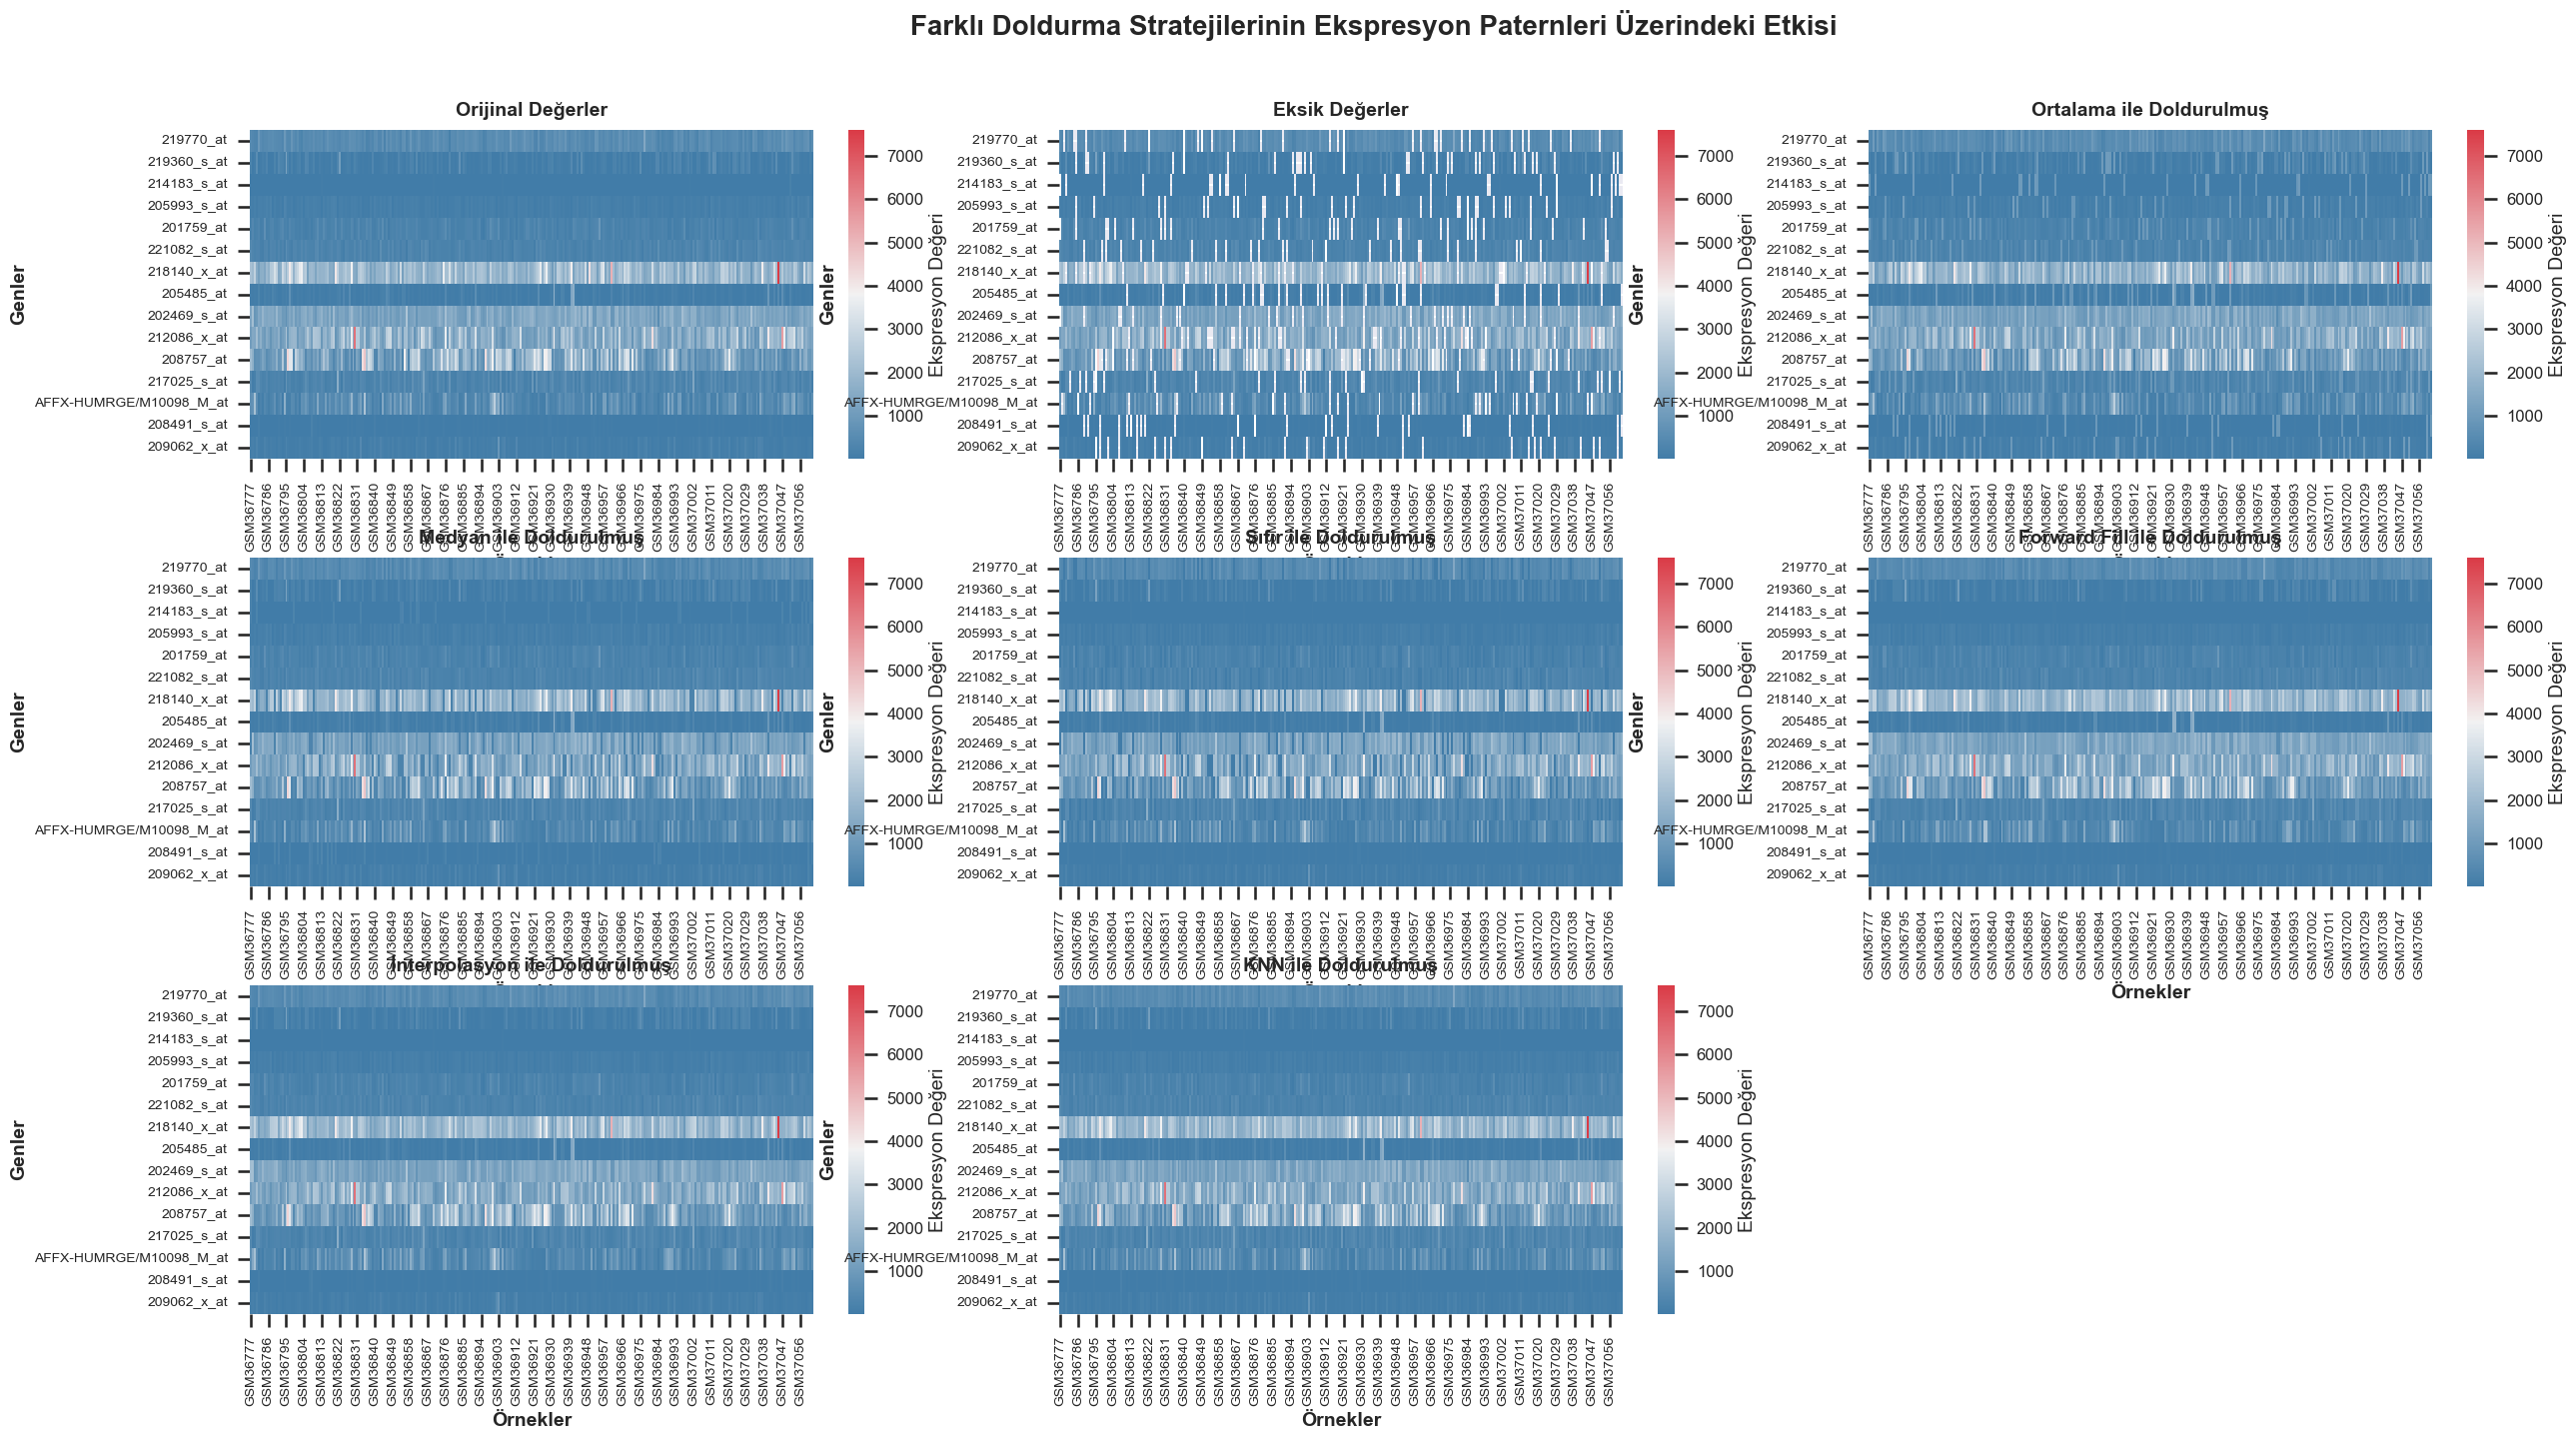

In [11]:
#7.5. Heatmap ile karşılaştırma (Geliştirilmiş)
# En yüksek 15 eksik değere sahip genlerin heatmap'i
top_missing_genes = missing_by_gene.sort_values(ascending=False).head(15).index

# Renk ölçeği oluşturma
vmin = np.min(exprs_original.loc[top_missing_genes].values)
vmax = np.max(exprs_original.loc[top_missing_genes].values)
cmap = sns.diverging_palette(240, 10, as_cmap=True)

plt.figure(figsize=(30, 15))

# Heatmap sayısı ve yerleşim
n_methods = len(methods)
cols = 3  # Her satırda 3 heatmap
rows = (n_methods + 2) // cols + ((n_methods + 2) % cols > 0)  # Orijinal + Eksik veri + Yöntemler için satır sayısı

# Tutarlı eksen ölçekleri için alt grafikler oluşturma
gs = mpl.gridspec.GridSpec(rows, cols, wspace=0.15, hspace=0.3)

# Orijinal veri heatmap
ax_orig = plt.subplot(gs[0, 0])
sns.heatmap(exprs_original.loc[top_missing_genes], cmap=cmap, vmin=vmin, vmax=vmax, 
           ax=ax_orig, cbar_kws={'label': 'Ekspresyon Değeri'})
ax_orig.set_title('Orijinal Değerler', fontsize=14, fontweight='bold', pad=10)
ax_orig.set_xlabel('Örnekler', fontweight='bold')
ax_orig.set_ylabel('Genler', fontweight='bold')
ax_orig.tick_params(labelsize=10)

# Eksik verili heatmap
ax_missing = plt.subplot(gs[0, 1])
# Eksik verileri görselleştirmek için maske uygulama
masked_data = exprs_with_missing.loc[top_missing_genes].copy()
heatmap_mask = np.isnan(masked_data)  # Farklı isim kullanıyoruz - heatmap_mask
sns.heatmap(masked_data, cmap=cmap, vmin=vmin, vmax=vmax, 
           ax=ax_missing, cbar_kws={'label': 'Ekspresyon Değeri'}, mask=heatmap_mask)
ax_missing.set_title('Eksik Değerler', fontsize=14, fontweight='bold', pad=10)
ax_missing.set_xlabel('Örnekler', fontweight='bold')
ax_missing.set_ylabel('Genler', fontweight='bold')
ax_missing.tick_params(labelsize=10)

# Her yöntem için heatmap oluşturma
for i, (name, df) in enumerate(methods.items()):
    row_idx = (i + 2) // cols  # +2 because orijinal and missing heatmaps
    col_idx = (i + 2) % cols
    
    ax = plt.subplot(gs[row_idx, col_idx])
    sns.heatmap(df.loc[top_missing_genes], cmap=cmap, vmin=vmin, vmax=vmax, 
               ax=ax, cbar_kws={'label': 'Ekspresyon Değeri'})
    ax.set_title(f'{name} ile Doldurulmuş', fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Örnekler', fontweight='bold')
    ax.set_ylabel('Genler', fontweight='bold')
    ax.tick_params(labelsize=10)

plt.suptitle('Farklı Doldurma Stratejilerinin Ekspresyon Paternleri Üzerindeki Etkisi', 
             fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

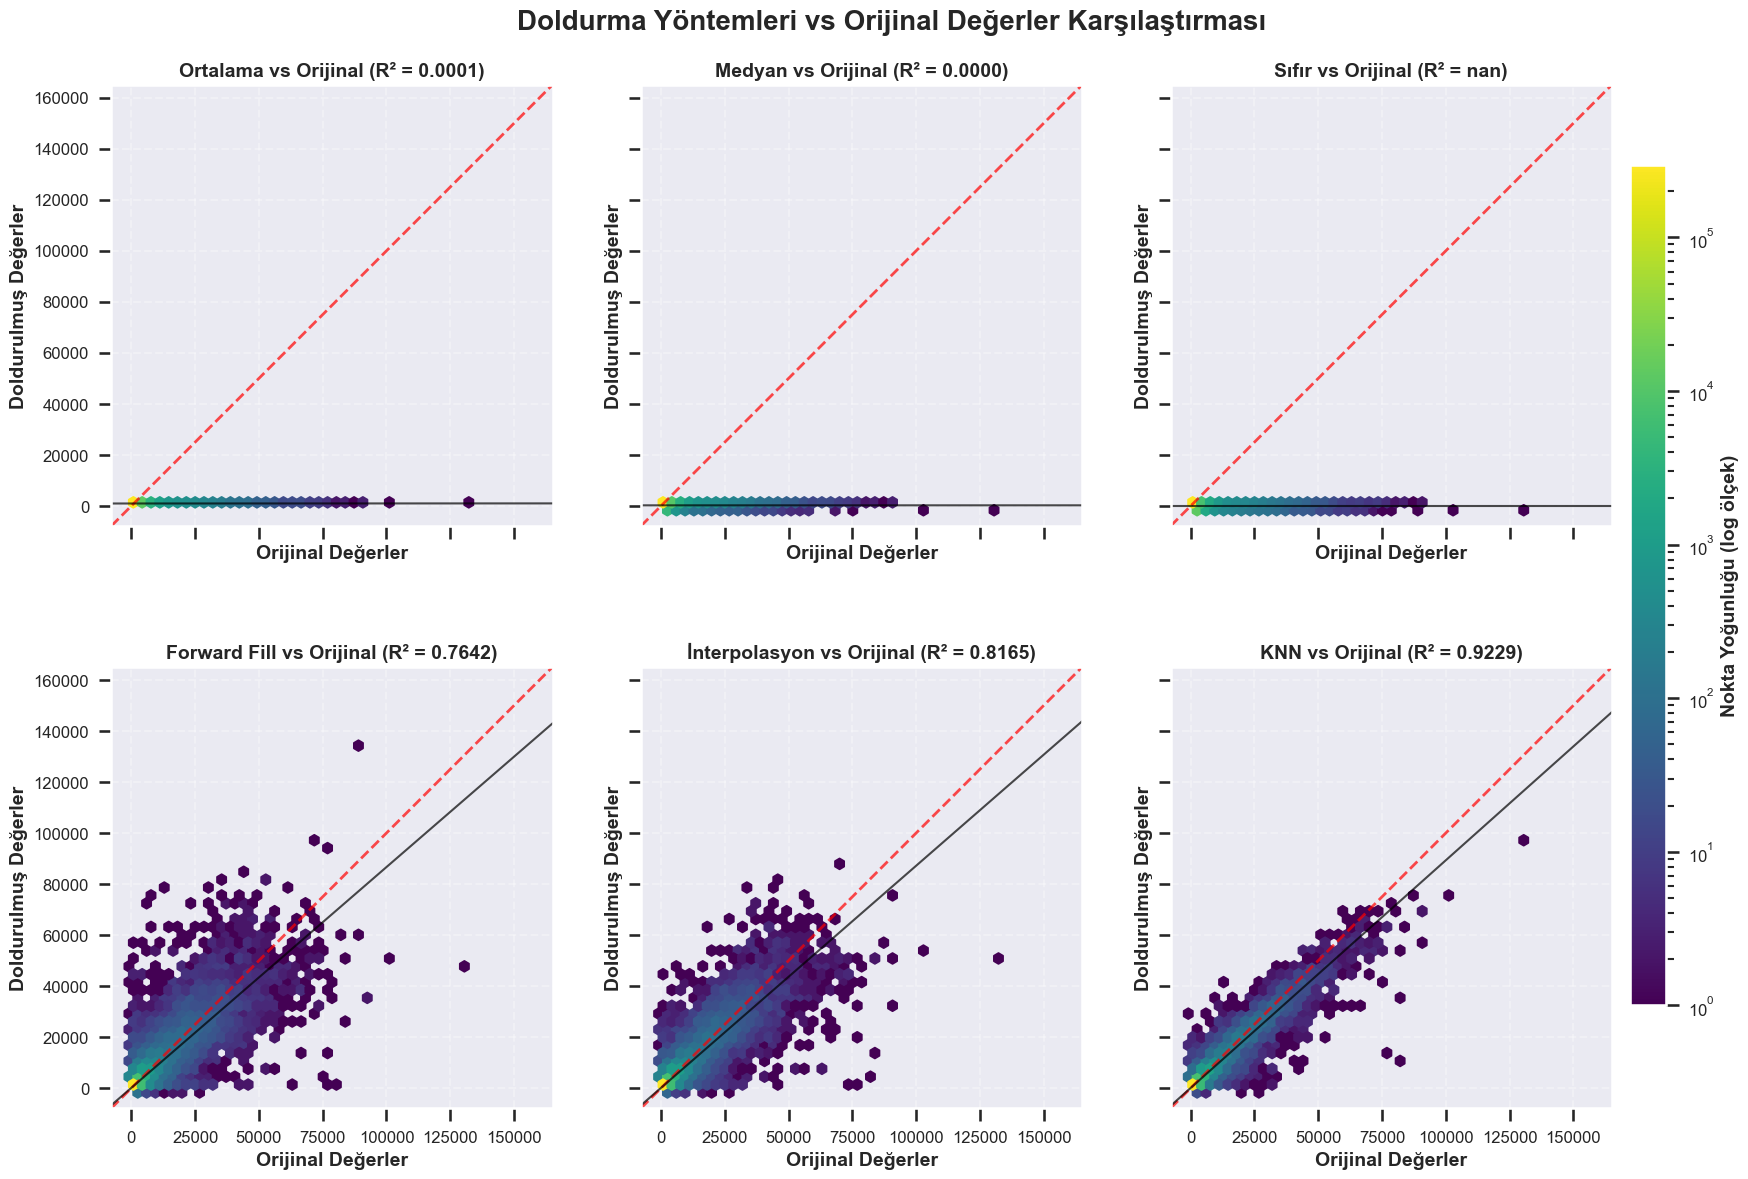

In [12]:


# 7.6. Scatter plot - Doldurulmuş vs Orijinal değerler (Geliştirilmiş)
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Eksen sınırları için veri aralığı
data_min = np.min(exprs_original.values)
data_max = np.max(exprs_original.values)
range_buffer = (data_max - data_min) * 0.05
x_range = [data_min - range_buffer, data_max + range_buffer]
y_range = [data_min - range_buffer, data_max + range_buffer]

# Her yöntem için karşılaştırmalı scatter plot oluşturma
for i, (name, df) in enumerate(methods.items()):
    ax = axes[i]
    
    # Hexbin plot (yoğunluğu göstermek için)
    # DÜZELTME: original_mask kullanarak doğru boyutlu maske uygulama
    original_values = exprs_original.values[original_mask]
    imputed_values = df.values[original_mask]
    
    hb = ax.hexbin(original_values, imputed_values, 
               gridsize=50, cmap='viridis', mincnt=1, bins='log',
               extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
    
    # Mükemmel tahmin çizgisi
    ax.plot(x_range, y_range, 'r--', alpha=0.7, linewidth=2)
    
    # Regresyon çizgisi
    z = np.polyfit(original_values.flatten(), imputed_values.flatten(), 1)
    p = np.poly1d(z)
    ax.plot(x_range, p(x_range), 'k-', alpha=0.7, linewidth=1.5)
    
    # R-kare değeri hesaplama
    corr_coef = np.corrcoef(original_values.flatten(), imputed_values.flatten())[0, 1]
    r_squared = corr_coef**2
    
    ax.set_title(f'{name} vs Orijinal (R² = {r_squared:.4f})', fontsize=14, fontweight='bold')
    ax.set_xlabel('Orijinal Değerler', fontweight='bold')
    ax.set_ylabel('Doldurulmuş Değerler', fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Eksenleri eşit ölçekte ayarlama
    ax.set_aspect('equal')
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)

# Renk çubuğu
cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])  # [x, y, width, height]
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.set_label('Nokta Yoğunluğu (log ölçek)', fontweight='bold')

plt.suptitle('Doldurma Yöntemleri vs Orijinal Değerler Karşılaştırması', 
             fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(right=0.9, top=0.92, wspace=0.2, hspace=0.3)
plt.show()